# PROJET ML - NOTEBOOK
## CHALLENGE  : AI POWERED VISUAL INSPECTION FOR MANUFACTURING by VALEO
## Import des modules

In [1]:
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
import numpy as np
from glob import glob
from PIL import ImageFile
import random
from tqdm import tqdm

import tensorflow as tf
from keras.preprocessing import image
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

## Import des donnée : tables liant le nom des photos à l'output (0 ou 1)

In [3]:
test = pd.read_csv("Y_Benchmark.csv" )
train = pd.read_csv("y_train_ExZpBft.csv" )

In [4]:
print(train.sample(5))
print(test.sample(5))

                              images  labels
9284  AE00227_190138_00_2_4_2001.jpg       1
361   AE00281_012729_00_2_3_2001.jpg       1
5642  AE00544_070649_00_1_4_2001.jpg       1
5771  AE00305_191644_00_2_3_2001.jpg       1
6996  AE00248_092700_00_3_3_2001.jpg       1
                              images  labels
563   AE00549_232227_00_1_4_2001.jpg       1
1833  AE00453_153443_00_4_2_2001.jpg       1
139   AE00352_111211_00_3_4_2001.jpg       1
616   AE00182_033810_00_3_2_2001.jpg       1
230   AE00227_181809_00_2_2_2001.jpg       1


## Sampling de 2000 images pour train/validation et de 400 en test

In [5]:
print(train.shape)
train_1000 = train.sample(2000, random_state = 42)
print(train_1000.shape)

print(test.shape)
test_new = test.sample(400, random_state = 42)
print(test_new.shape)

(10609, 2)
(2000, 2)
(1988, 2)
(400, 2)


## On ajoute le chemin d'emplacement des images

In [6]:
train_0 = train_1000.query('labels == 0')
train_0['path'] = 'x_train/1/' + train_0['images'].astype(str)
train_1 = train_1000.query('labels == 1')
train_1['path'] = 'x_train/2/' + train_1['images'].astype(str)
print(len(train_0))
print(len(train_1))

train_new = pd.concat([train_0,train_1])

test_new['path'] = 'x_test/' + test_new['images'].astype(str)

754
1246


<ipython-input-6-fffb2269fc72>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_0['path'] = 'x_train/1/' + train_0['images'].astype(str)
<ipython-input-6-fffb2269fc72>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_1['path'] = 'x_train/2/' + train_1['images'].astype(str)


In [7]:
print(train_new.sample(5))
print(test_new.sample(5))

                               images  labels  \
10593  AE00379_014107_00_1_3_2001.jpg       0   
7037   AE00385_023907_00_1_1_2001.jpg       1   
6214   AE00343_225527_00_4_1_2001.jpg       1   
5146   AE00382_084558_00_3_3_2001.jpg       1   
3058   AE00299_041514_00_3_4_2001.jpg       1   

                                           path  
10593  x_train/1/AE00379_014107_00_1_3_2001.jpg  
7037   x_train/2/AE00385_023907_00_1_1_2001.jpg  
6214   x_train/2/AE00343_225527_00_4_1_2001.jpg  
5146   x_train/2/AE00382_084558_00_3_3_2001.jpg  
3058   x_train/2/AE00299_041514_00_3_4_2001.jpg  
                              images  labels  \
1421  AE00500_233110_00_1_1_2001.jpg       0   
1078  AE00432_132053_00_4_2_2001.jpg       1   
1222  AE00427_084116_00_3_1_2001.jpg       0   
1815  AE00501_160241_00_4_3_2001.jpg       0   
281   AE00348_044724_00_1_3_2001.jpg       1   

                                       path  
1421  x_test/AE00500_233110_00_1_1_2001.jpg  
1078  x_test/AE00432_132

## On obtient les chemins des images et les 'labels' (0 ou 1)

In [8]:
train_validate_files = train_new['path']
train_validate_targets = train_new['labels']
test_files = test_new['path']
test_targets = test_new['labels']

## On sépare l'achantillon de train/validation en train (1500 images) et validation (500 images)

In [9]:
train_files, valid_files, train_targets, valid_targets = \
    train_test_split(train_validate_files, train_validate_targets, test_size=0.25, random_state=42)

## On importe les images, on réduit leur taille à 200 X 200 pixels

In [10]:
def path_to_tensor(img_path):

    img = image.load_img(img_path, target_size=(200, 200),color_mode='grayscale',interpolation='nearest')
    img_array = image.img_to_array(img)

    return np.expand_dims(img_array, axis=0)

def paths_to_tensor(img_paths):
    
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [11]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255

100%|██████████| 500/500 [00:30<00:00, 16.23it/s]


#### Erratum: the test image 'AE00072_145326_00_1_2_2001.jpg' is missing. Please ignore it,

In [12]:
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 400/400 [00:25<00:00, 15.94it/s]


# Baseline models
## Aucune couche : baseline 1 = réseau sans hidden layer = équivalent regression logistique

In [15]:
model = Sequential()

model.add(tf.keras.Input(shape=(200,200,1)))
#model.add(MaxPooling2D(pool_size=8))

model.add(Flatten())

model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 40001     
Total params: 40,001
Trainable params: 40,001
Non-trainable params: 0
_________________________________________________________________


In [17]:
epochs = 40

model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=50, verbose=1)

Epoch 1/40
30/30 [==============================] - 1s 28ms/step - loss: 0.1534 - accuracy: 0.9527 - val_loss: 0.1981 - val_accuracy: 0.9300
Epoch 2/40
30/30 [==============================] - 1s 33ms/step - loss: 0.1500 - accuracy: 0.9580 - val_loss: 0.2126 - val_accuracy: 0.9280
Epoch 3/40
30/30 [==============================] - 1s 18ms/step - loss: 0.1553 - accuracy: 0.9547 - val_loss: 0.2062 - val_accuracy: 0.9360
Epoch 4/40
30/30 [==============================] - 1s 17ms/step - loss: 0.1489 - accuracy: 0.9553 - val_loss: 0.1915 - val_accuracy: 0.9440
Epoch 5/40
30/30 [==============================] - 1s 21ms/step - loss: 0.1351 - accuracy: 0.9667 - val_loss: 0.1879 - val_accuracy: 0.9380
Epoch 6/40
30/30 [==============================] - 0s 13ms/step - loss: 0.1278 - accuracy: 0.9700 - val_loss: 0.1871 - val_accuracy: 0.9400
Epoch 7/40
30/30 [==============================] - 0s 14ms/step - loss: 0.1278 - accuracy: 0.9673 - val_loss: 0.2034 - val_accuracy: 0.9500
Epoch 8/40
30

## Baseline 2 = réseau avec 2 hidden layers mais toujours sans convolution

In [20]:
model = Sequential()

model.add(tf.keras.Input(shape=(200,200,1)))
model.add(MaxPooling2D(pool_size=8))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 1)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 625)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               160256    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 193,281
Trainable params: 193,281
Non-trainable params: 0
________________________________________________

In [21]:
epochs = 40

model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=50, verbose=1)

Epoch 1/40
30/30 [==============================] - 4s 149ms/step - loss: 0.5348 - accuracy: 0.7260 - val_loss: 0.4788 - val_accuracy: 0.7860
Epoch 2/40
30/30 [==============================] - 2s 66ms/step - loss: 0.4673 - accuracy: 0.7760 - val_loss: 0.4635 - val_accuracy: 0.7980
Epoch 3/40
30/30 [==============================] - 2s 63ms/step - loss: 0.4477 - accuracy: 0.7927 - val_loss: 0.4542 - val_accuracy: 0.7880
Epoch 4/40
30/30 [==============================] - 2s 61ms/step - loss: 0.4386 - accuracy: 0.7833 - val_loss: 0.4309 - val_accuracy: 0.7860
Epoch 5/40
30/30 [==============================] - 2s 62ms/step - loss: 0.4145 - accuracy: 0.8260 - val_loss: 0.4174 - val_accuracy: 0.7920
Epoch 6/40
30/30 [==============================] - 2s 73ms/step - loss: 0.4003 - accuracy: 0.8167 - val_loss: 0.4065 - val_accuracy: 0.8600
Epoch 7/40
30/30 [==============================] - 2s 68ms/step - loss: 0.3857 - accuracy: 0.8393 - val_loss: 0.4024 - val_accuracy: 0.8700
Epoch 8/40
3

# CNN : ajouts de couches de convolutions
## 1 couche de concvolution

In [73]:
model = Sequential()

model.add(Conv2D(filters=8, kernel_size=2, padding='same',
                 activation='relu', input_shape=(200, 200,1)))
model.add(MaxPooling2D(pool_size=20))


model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_83 (Conv2D)           (None, 200, 200, 8)       40        
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 10, 10, 8)         0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 800)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 256)               205056    
_________________________________________________________________
dropout_83 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_83 (Dense)             (None, 1)               

In [74]:
epochs = 20

model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=50, verbose=1)

Epoch 1/20
30/30 [==============================] - 17s 574ms/step - loss: 0.5414 - accuracy: 0.7253 - val_loss: 0.4761 - val_accuracy: 0.7860
Epoch 2/20
30/30 [==============================] - 12s 415ms/step - loss: 0.4501 - accuracy: 0.7987 - val_loss: 0.4236 - val_accuracy: 0.7860
Epoch 3/20
30/30 [==============================] - 12s 409ms/step - loss: 0.3918 - accuracy: 0.8227 - val_loss: 0.3999 - val_accuracy: 0.8560
Epoch 4/20
30/30 [==============================] - 12s 405ms/step - loss: 0.3129 - accuracy: 0.8960 - val_loss: 0.2883 - val_accuracy: 0.9020
Epoch 5/20
30/30 [==============================] - 12s 400ms/step - loss: 0.2653 - accuracy: 0.9087 - val_loss: 0.2430 - val_accuracy: 0.9060
Epoch 6/20
30/30 [==============================] - 13s 418ms/step - loss: 0.2388 - accuracy: 0.9153 - val_loss: 0.2524 - val_accuracy: 0.9120
Epoch 7/20
30/30 [==============================] - 12s 412ms/step - loss: 0.2319 - accuracy: 0.9213 - val_loss: 0.2203 - val_accuracy: 0.9080

## 2 couches

In [52]:
model = Sequential()

model.add(Conv2D(filters=4, kernel_size=2, padding='same',
                 activation='relu', input_shape=(200, 200,1)))
model.add(MaxPooling2D(pool_size=5))

model.add(Conv2D(filters=8, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=4))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 200, 200, 4)       20        
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 40, 40, 4)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 40, 40, 8)         136       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 10, 10, 8)         0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 10, 10, 8)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)              

In [53]:
epochs = 20

model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=50, verbose=1)

Epoch 1/20
30/30 [==============================] - 14s 468ms/step - loss: 0.5871 - accuracy: 0.6807 - val_loss: 0.4691 - val_accuracy: 0.7860
Epoch 2/20
30/30 [==============================] - 13s 432ms/step - loss: 0.4461 - accuracy: 0.7967 - val_loss: 0.4314 - val_accuracy: 0.8000
Epoch 3/20
30/30 [==============================] - 13s 425ms/step - loss: 0.3856 - accuracy: 0.8373 - val_loss: 0.3575 - val_accuracy: 0.8860
Epoch 4/20
30/30 [==============================] - 13s 427ms/step - loss: 0.3279 - accuracy: 0.8720 - val_loss: 0.3290 - val_accuracy: 0.8880
Epoch 5/20
30/30 [==============================] - 13s 443ms/step - loss: 0.3149 - accuracy: 0.8840 - val_loss: 0.2996 - val_accuracy: 0.9120
Epoch 6/20
30/30 [==============================] - 13s 423ms/step - loss: 0.2467 - accuracy: 0.9127 - val_loss: 0.2420 - val_accuracy: 0.9040
Epoch 7/20
30/30 [==============================] - 12s 415ms/step - loss: 0.2582 - accuracy: 0.9000 - val_loss: 0.2599 - val_accuracy: 0.9200

In [54]:
model = Sequential()

model.add(Conv2D(filters=8, kernel_size=2, padding='same',
                 activation='relu', input_shape=(200, 200,1)))
model.add(MaxPooling2D(pool_size=6))

model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=5))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 200, 200, 8)       40        
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 33, 33, 8)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 33, 33, 16)        528       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 6, 6, 16)          0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)              

In [55]:
epochs = 20

model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=50, verbose=1)

Epoch 1/20
30/30 [==============================] - 15s 494ms/step - loss: 0.5753 - accuracy: 0.6867 - val_loss: 0.4837 - val_accuracy: 0.7860
Epoch 2/20
30/30 [==============================] - 12s 410ms/step - loss: 0.4724 - accuracy: 0.7693 - val_loss: 0.4544 - val_accuracy: 0.7940
Epoch 3/20
30/30 [==============================] - 12s 414ms/step - loss: 0.4281 - accuracy: 0.7967 - val_loss: 0.4242 - val_accuracy: 0.8400
Epoch 4/20
30/30 [==============================] - 12s 404ms/step - loss: 0.3955 - accuracy: 0.8360 - val_loss: 0.3833 - val_accuracy: 0.8460
Epoch 5/20
30/30 [==============================] - 15s 497ms/step - loss: 0.3714 - accuracy: 0.8453 - val_loss: 0.3723 - val_accuracy: 0.8380
Epoch 6/20
30/30 [==============================] - 14s 464ms/step - loss: 0.3379 - accuracy: 0.8687 - val_loss: 0.3132 - val_accuracy: 0.8920
Epoch 7/20
30/30 [==============================] - 13s 420ms/step - loss: 0.2777 - accuracy: 0.9100 - val_loss: 0.2684 - val_accuracy: 0.9320

## 3 couches

In [69]:
model = Sequential()

model.add(Conv2D(filters=4, kernel_size=2, padding='same',
                 activation='relu', input_shape=(200, 200,1)))
model.add(MaxPooling2D(pool_size=3))

model.add(Conv2D(filters=8, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 200, 200, 4)       20        
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 66, 66, 4)         0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 66, 66, 8)         136       
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 22, 22, 8)         0         
_________________________________________________________________
dropout_78 (Dropout)         (None, 22, 22, 8)         0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 22, 22, 16)        528       
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 7, 7, 16)        

In [70]:
epochs = 20

model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=50, verbose=1)

Epoch 1/20
30/30 [==============================] - 17s 567ms/step - loss: 0.5699 - accuracy: 0.6980 - val_loss: 0.4659 - val_accuracy: 0.7860
Epoch 2/20
30/30 [==============================] - 15s 496ms/step - loss: 0.4664 - accuracy: 0.7760 - val_loss: 0.4496 - val_accuracy: 0.7980
Epoch 3/20
30/30 [==============================] - 14s 456ms/step - loss: 0.4316 - accuracy: 0.7927 - val_loss: 0.4253 - val_accuracy: 0.8160
Epoch 4/20
30/30 [==============================] - 14s 452ms/step - loss: 0.4142 - accuracy: 0.8053 - val_loss: 0.4047 - val_accuracy: 0.8240
Epoch 5/20
30/30 [==============================] - 14s 462ms/step - loss: 0.3911 - accuracy: 0.8447 - val_loss: 0.3852 - val_accuracy: 0.8720
Epoch 6/20
30/30 [==============================] - 15s 507ms/step - loss: 0.3720 - accuracy: 0.8613 - val_loss: 0.3584 - val_accuracy: 0.8860
Epoch 7/20
30/30 [==============================] - 15s 487ms/step - loss: 0.3238 - accuracy: 0.8880 - val_loss: 0.3120 - val_accuracy: 0.8840

## 4 couches

In [66]:
model = Sequential()

model.add(Conv2D(filters=4, kernel_size=2, padding='same',
                 activation='relu', input_shape=(200, 200,1)))
model.add(MaxPooling2D(pool_size=3))

model.add(Conv2D(filters=8, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters=12, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 200, 200, 4)       20        
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 66, 66, 4)         0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 66, 66, 8)         136       
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 33, 33, 8)         0         
_________________________________________________________________
dropout_69 (Dropout)         (None, 33, 33, 8)         0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 33, 33, 12)        396       
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 16, 16, 12)      

In [67]:
epochs = 20

model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=50, verbose=1)

Epoch 1/20
30/30 [==============================] - 16s 540ms/step - loss: 0.5525 - accuracy: 0.7167 - val_loss: 0.5111 - val_accuracy: 0.7880
Epoch 2/20
30/30 [==============================] - 17s 556ms/step - loss: 0.4595 - accuracy: 0.7853 - val_loss: 0.4537 - val_accuracy: 0.7880
Epoch 3/20
30/30 [==============================] - 16s 533ms/step - loss: 0.4233 - accuracy: 0.7960 - val_loss: 0.4261 - val_accuracy: 0.8220
Epoch 4/20
30/30 [==============================] - 15s 503ms/step - loss: 0.4024 - accuracy: 0.8307 - val_loss: 0.3886 - val_accuracy: 0.9040
Epoch 5/20
30/30 [==============================] - 15s 489ms/step - loss: 0.3550 - accuracy: 0.8793 - val_loss: 0.3363 - val_accuracy: 0.9000
Epoch 6/20
30/30 [==============================] - 16s 531ms/step - loss: 0.2762 - accuracy: 0.9107 - val_loss: 0.2692 - val_accuracy: 0.9100
Epoch 7/20
30/30 [==============================] - 16s 524ms/step - loss: 0.2306 - accuracy: 0.9213 - val_loss: 0.2349 - val_accuracy: 0.9440

## 5 couches de convolution (kernel size = 2, stride = (1,1)) : meilleur modèle

In [13]:
model = Sequential()

model.add(Conv2D(filters=4, kernel_size=2, padding='same',
                 activation='relu', input_shape=(200, 200,1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters=8, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters=12, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters=20, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 4)       20        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 4)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 8)       136       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 12)        396       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 12)        0

## Premier fit

In [25]:
epochs = 20

model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=50, verbose=1)

Epoch 1/20
30/30 [==============================] - 21s 708ms/step - loss: 0.5948 - accuracy: 0.6667 - val_loss: 0.4609 - val_accuracy: 0.7860
Epoch 2/20
30/30 [==============================] - 19s 637ms/step - loss: 0.4143 - accuracy: 0.8340 - val_loss: 0.3750 - val_accuracy: 0.8880
Epoch 3/20
30/30 [==============================] - 18s 611ms/step - loss: 0.3308 - accuracy: 0.8907 - val_loss: 0.3220 - val_accuracy: 0.9000
Epoch 4/20
30/30 [==============================] - 19s 621ms/step - loss: 0.2712 - accuracy: 0.9093 - val_loss: 0.2489 - val_accuracy: 0.9100
Epoch 5/20
30/30 [==============================] - 18s 616ms/step - loss: 0.2243 - accuracy: 0.9220 - val_loss: 0.2365 - val_accuracy: 0.9180
Epoch 6/20
30/30 [==============================] - 19s 618ms/step - loss: 0.2185 - accuracy: 0.9207 - val_loss: 0.2232 - val_accuracy: 0.9180
Epoch 7/20
30/30 [==============================] - 20s 656ms/step - loss: 0.2379 - accuracy: 0.9147 - val_loss: 0.2352 - val_accuracy: 0.9140

## Second fit

In [59]:
epochs = 20

from numpy.random import seed
seed(42)

model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=50, verbose=1)

Epoch 1/20
30/30 [==============================] - 20s 673ms/step - loss: 0.5644 - accuracy: 0.6767 - val_loss: 0.4678 - val_accuracy: 0.7860
Epoch 2/20
30/30 [==============================] - 19s 641ms/step - loss: 0.4353 - accuracy: 0.7933 - val_loss: 0.4294 - val_accuracy: 0.8060
Epoch 3/20
30/30 [==============================] - 19s 634ms/step - loss: 0.4010 - accuracy: 0.8187 - val_loss: 0.3950 - val_accuracy: 0.8240
Epoch 4/20
30/30 [==============================] - 18s 616ms/step - loss: 0.3614 - accuracy: 0.8427 - val_loss: 0.3743 - val_accuracy: 0.8640
Epoch 5/20
30/30 [==============================] - 19s 633ms/step - loss: 0.2711 - accuracy: 0.9093 - val_loss: 0.2373 - val_accuracy: 0.9380
Epoch 6/20
30/30 [==============================] - 19s 630ms/step - loss: 0.1958 - accuracy: 0.9353 - val_loss: 0.1682 - val_accuracy: 0.9540
Epoch 7/20
30/30 [==============================] - 20s 656ms/step - loss: 0.1451 - accuracy: 0.9600 - val_loss: 0.1432 - val_accuracy: 0.9500

## Troisième fit

In [14]:
epochs = 20

model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=50, verbose=1)

Epoch 1/20
30/30 [==============================] - 25s 821ms/step - loss: 0.5954 - accuracy: 0.6540 - val_loss: 0.4964 - val_accuracy: 0.7860
Epoch 2/20
30/30 [==============================] - 19s 622ms/step - loss: 0.4500 - accuracy: 0.7853 - val_loss: 0.4603 - val_accuracy: 0.8240
Epoch 3/20
30/30 [==============================] - 18s 606ms/step - loss: 0.4207 - accuracy: 0.8033 - val_loss: 0.4369 - val_accuracy: 0.8240
Epoch 4/20
30/30 [==============================] - 19s 639ms/step - loss: 0.4187 - accuracy: 0.8067 - val_loss: 0.4421 - val_accuracy: 0.8300
Epoch 5/20
30/30 [==============================] - 19s 618ms/step - loss: 0.4142 - accuracy: 0.8007 - val_loss: 0.4221 - val_accuracy: 0.8240
Epoch 6/20
30/30 [==============================] - 19s 627ms/step - loss: 0.4062 - accuracy: 0.8087 - val_loss: 0.4457 - val_accuracy: 0.8240
Epoch 7/20
30/30 [==============================] - 19s 620ms/step - loss: 0.4035 - accuracy: 0.8100 - val_loss: 0.4312 - val_accuracy: 0.8380

## 5 couches, kernel-size = 3, stride = (1,1)

In [83]:
model = Sequential()

model.add(Conv2D(filters=4, kernel_size=3, padding='same',
                 activation='relu', input_shape=(200, 200,1)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=8, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters=12, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters=20, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_84 (Conv2D)           (None, 200, 200, 4)       40        
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 100, 100, 4)       0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 100, 100, 8)       296       
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 50, 50, 8)         0         
_________________________________________________________________
dropout_90 (Dropout)         (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 50, 50, 12)        876       
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 25, 25, 12)      

In [84]:
epochs = 20

model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=50, verbose=1)

Epoch 1/20
30/30 [==============================] - 29s 960ms/step - loss: 0.5876 - accuracy: 0.6773 - val_loss: 0.4614 - val_accuracy: 0.7860
Epoch 2/20
30/30 [==============================] - 26s 876ms/step - loss: 0.4214 - accuracy: 0.8080 - val_loss: 0.3725 - val_accuracy: 0.8680
Epoch 3/20
30/30 [==============================] - 26s 870ms/step - loss: 0.3121 - accuracy: 0.8933 - val_loss: 0.2905 - val_accuracy: 0.9020
Epoch 4/20
30/30 [==============================] - 25s 848ms/step - loss: 0.2822 - accuracy: 0.9013 - val_loss: 0.2804 - val_accuracy: 0.9020
Epoch 5/20
30/30 [==============================] - 25s 842ms/step - loss: 0.2449 - accuracy: 0.9173 - val_loss: 0.2326 - val_accuracy: 0.9140
Epoch 6/20
30/30 [==============================] - 25s 834ms/step - loss: 0.2213 - accuracy: 0.9220 - val_loss: 0.2338 - val_accuracy: 0.9160
Epoch 7/20
30/30 [==============================] - 26s 854ms/step - loss: 0.2016 - accuracy: 0.9253 - val_loss: 0.2250 - val_accuracy: 0.9440

## 5 couches avec kernel = 2, mais pas de maxpooling, on met un 'stride' de (2,2) pour réduire la dimension

In [22]:
model = Sequential()

model.add(Conv2D(filters=4, kernel_size=2, strides= (2,2),padding='same',
                 activation='relu', input_shape=(200, 200,1)))

model.add(Conv2D(filters=8, kernel_size=2, strides= (2,2),padding='same', activation='relu'))
model.add(Dropout(0.1))

model.add(Conv2D(filters=12, kernel_size=2, strides= (2,2),padding='same', activation='relu'))
model.add(Dropout(0.1))

model.add(Conv2D(filters=16, kernel_size=2, strides= (2,2),padding='same', activation='relu'))
model.add(Dropout(0.1))

model.add(Conv2D(filters=20, kernel_size=2, strides= (2,2),padding='same', activation='relu'))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 4)       20        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 8)         136       
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 12)        396       
_________________________________________________________________
dropout_3 (Dropout)          (None, 25, 25, 12)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 16)        784       
_________________________________________________________________
dropout_4 (Dropout)          (None, 13, 13, 16)       

In [23]:
epochs = 20

model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=50, verbose=1)

Epoch 1/20
30/30 [==============================] - 7s 234ms/step - loss: 0.5087 - accuracy: 0.7400 - val_loss: 0.4496 - val_accuracy: 0.8020
Epoch 2/20
30/30 [==============================] - 5s 171ms/step - loss: 0.4286 - accuracy: 0.7967 - val_loss: 0.4149 - val_accuracy: 0.8240
Epoch 3/20
30/30 [==============================] - 5s 161ms/step - loss: 0.4174 - accuracy: 0.8013 - val_loss: 0.4259 - val_accuracy: 0.8240
Epoch 4/20
30/30 [==============================] - 4s 145ms/step - loss: 0.4110 - accuracy: 0.8067 - val_loss: 0.4125 - val_accuracy: 0.8240
Epoch 5/20
30/30 [==============================] - 5s 158ms/step - loss: 0.4076 - accuracy: 0.8113 - val_loss: 0.4096 - val_accuracy: 0.8240
Epoch 6/20
30/30 [==============================] - 5s 166ms/step - loss: 0.4075 - accuracy: 0.8147 - val_loss: 0.4107 - val_accuracy: 0.8240
Epoch 7/20
30/30 [==============================] - 5s 156ms/step - loss: 0.4003 - accuracy: 0.8207 - val_loss: 0.3900 - val_accuracy: 0.8240
Epoch 

## 6 couches

In [37]:
model = Sequential()

model.add(Conv2D(filters=4, kernel_size=2, padding='same',
                 activation='relu', input_shape=(200, 200,1)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=8, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters=12, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters=20, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters=24, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(216, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(108, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 200, 200, 4)       20        
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 100, 100, 4)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 100, 100, 8)       136       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 50, 50, 8)         0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 50, 50, 12)        396       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 25, 25, 12)       

In [38]:
epochs = 20

model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=50, verbose=1)

Epoch 1/20
30/30 [==============================] - 23s 750ms/step - loss: 0.6563 - accuracy: 0.6247 - val_loss: 0.6374 - val_accuracy: 0.5960
Epoch 2/20
30/30 [==============================] - 19s 639ms/step - loss: 0.5478 - accuracy: 0.7120 - val_loss: 0.4886 - val_accuracy: 0.7840
Epoch 3/20
30/30 [==============================] - 19s 643ms/step - loss: 0.4748 - accuracy: 0.7660 - val_loss: 0.4698 - val_accuracy: 0.7900
Epoch 4/20
30/30 [==============================] - 19s 617ms/step - loss: 0.4450 - accuracy: 0.7960 - val_loss: 0.4557 - val_accuracy: 0.8060
Epoch 5/20
30/30 [==============================] - 18s 605ms/step - loss: 0.4299 - accuracy: 0.8013 - val_loss: 0.4415 - val_accuracy: 0.8200
Epoch 6/20
30/30 [==============================] - 19s 644ms/step - loss: 0.4186 - accuracy: 0.8067 - val_loss: 0.4204 - val_accuracy: 0.8160
Epoch 7/20
30/30 [==============================] - 20s 660ms/step - loss: 0.4252 - accuracy: 0.8080 - val_loss: 0.4205 - val_accuracy: 0.8220

# Evaluation du modèle retenu (5 couches)
## Prediction sur échantillon test (400 images)

In [33]:
predictions = [round(model.predict(np.expand_dims(tensor, axis=0))[0,0]) for tensor in test_tensors]
print(predictions)

[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0,

## Prédictions avec récupération des probabilité (entre 0 et 1) de manière à pouvoir hanger le seuil

In [15]:
predictions = [model.predict(np.expand_dims(tensor, axis=0))[0,0] for tensor in test_tensors]
print(predictions)

[0.9901123, 0.0013171732, 0.0019692779, 0.0030314326, 0.99061817, 0.9906813, 0.9487878, 0.9843567, 0.98895645, 0.9918337, 0.9969411, 0.9824065, 0.9741264, 0.9946107, 0.9954649, 0.9855695, 0.9906907, 0.9960546, 0.0013775826, 0.0013429523, 0.0011354387, 0.0010861158, 0.0139991045, 0.9850501, 0.9512263, 0.0012687147, 0.95701647, 0.0018898249, 0.0036892295, 0.0005489588, 0.0100027025, 0.9963255, 0.64293516, 0.0006634593, 0.9743413, 0.0016818643, 0.9927571, 0.9893127, 0.0014674067, 0.006174922, 0.13942608, 0.9404436, 0.9859476, 0.003655374, 0.9894687, 0.9965157, 0.9718585, 0.9769836, 0.010381907, 0.0065315664, 0.0004120767, 0.98872495, 0.9659101, 0.014884144, 0.98373735, 0.99661463, 0.00067317486, 0.13653257, 0.97847295, 0.9661018, 0.00074991584, 0.9842358, 0.0009562075, 0.0015995204, 0.07272819, 0.9659312, 0.97341084, 0.9775833, 0.9182472, 0.22888097, 0.0045704544, 0.9888143, 0.0017375052, 0.00093844533, 0.98829937, 0.99541116, 0.9761444, 0.0022743344, 0.76446563, 0.99846315, 0.00112468, 0

## Seuil à 0.5

In [16]:
a = np.empty(400)
a.fill(0.5)
predictions_1 = np.where(predictions > a, 1,0)
print(predictions_1)

[1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 1 0 1
 1 0 0 0 1 1 0 1 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1 0 1 0 0 0 1 1 1 1 0 0 1 0 0
 1 1 1 0 1 1 0 0 1 0 1 1 0 1 0 1 1 0 0 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 1 0 1
 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 0 1 1 0 0 1 1 1 0
 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 0 0 1
 0 1 1 0 1 1 0 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 1 0 1 1 0 1 1 0 1 1 1 1 1
 1 0 1 0 1 1 1 1 1 0 1 1 0 0 0 0 1 1 1 0 0 0 1 0 1 0 1 0 1 1 1 1 0 1 1 0 1
 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0
 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 0 0 0 1 0 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 0 0 1 1 1 0 0 1 1 1 0 1 1 0 1 1 0
 0 0 1 1 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 1 1 1 1 1 0 1 1 1]


## On augmente le seuil de détection des positifs de 0.5 à 0.9 ou 0.95

In [20]:
a = np.empty(400)
a.fill(0.95)
predictions_2 = np.where(predictions > a, 1,0)
print(predictions_2)

[1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 1
 1 0 0 0 0 1 0 1 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 1 0 0
 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 1 0 1 0 1 1 0 1 1 1 1 1 0 1
 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 0 1 1 0 0 1 0 1 0
 1 0 1 1 0 1 1 1 1 1 0 1 1 1 0 0 0 0 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 0 0 1
 0 1 1 0 1 1 0 1 0 0 1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 1 1 1 1 1
 1 0 1 0 1 1 1 1 1 0 1 1 0 0 0 0 0 1 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 0 1
 1 0 0 0 1 1 0 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0
 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1 0 0 0 0 1 0 0 1 1 0
 0 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 0 0 1 0 1 0 0 1 1 1 0 1 1 0 0 1 0
 0 0 1 1 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 1 1 1 1 1 0 1 1 1]


### Combien sont bien prédits (sur les 400) ?
#### Pour la première simulation (seuil = 0.5)

In [36]:
#print(predictions==test_targets)

print(sum(predictions_1==test_targets))

390


## Accuracy et Matrices de confusion, en ligne valeurs réels en colonne les prediction

### Première simulation (seuil = 0.5)

#### 155 vrais negatifs, 235 vrais positifs, 8 faux positifs, 2 faux négatifs

In [37]:
print(confusion_matrix(test_targets, predictions_1))

print(accuracy_score(test_targets, predictions_1))

[[155   8]
 [  2 235]]
0.975


In [56]:
a = np.zeros(400)
print(sum(predictions==a))
print(sum(test_targets==a))

157
163


## 2 eme simulation (seuil = 0.5)

In [68]:
print(confusion_matrix(test_targets, predictions_1))

print(accuracy_score(test_targets, predictions_1))

[[162   1]
 [  0 237]]
0.9975


## avec seuil = 0.9

In [75]:
print(confusion_matrix(test_targets, predictions_2))

print(accuracy_score(test_targets, predictions_2))

[[163   0]
 [  3 234]]
0.9925


## 3 eme simulation (seuil = 0.5)

In [17]:
print(confusion_matrix(test_targets, predictions_1))

print(accuracy_score(test_targets, predictions_1))

[[154   9]
 [  0 237]]
0.9775


## avec seuil = 0.9

In [19]:
print(confusion_matrix(test_targets, predictions_2))

print(accuracy_score(test_targets, predictions_2))

[[161   2]
 [  6 231]]
0.98


## avec seuil = 0.95

In [21]:
print(confusion_matrix(test_targets, predictions_2))

print(accuracy_score(test_targets, predictions_2))

[[163   0]
 [ 19 218]]
0.9525


## Annexe : taille d'une image

sample image shape:  (2415, 2070)


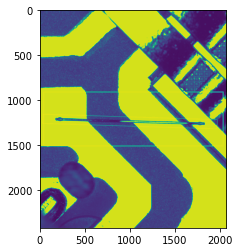

In [6]:
from skimage.io import imread
from skimage.transform import resize
#sample_image = imread("bumblebee.png")
sample_image = imread("AE00008_080949_00_2_2_2001.jpg")
sample_image= sample_image.astype(float)

size = sample_image.shape
print("sample image shape: ", sample_image.shape)

plt.imshow(sample_image.astype('uint8'))